# 3.Clustering analysis

## To run
Kernel = audio6
audio6_requirements.txt is the requirements.txt for that kernel.  

* Enter the pickle file names in box 16 if you want to change these

## Changes

* CA 10 Fixes to classification analytics for two classes ANT+BEL v DUB 
* CA 9 Added visual cluster analysis
* CA 9 added all numerical features to log reg model 9, added 
* CA 8 added a simple KNN classification
* CA 8 added demographics first to MFCC_delta for another log reg, then to MFCC_delta_2 for a second new log reg
* CA 7 correct and refine classification metrics for AUC and ROC, mix the gender, age and MFCC features in an LR classification
* CA 6 added balanced class labels, pushing genders and ages alone down to 55%, amended split to be on recording number, avoiding the classification working by the speaker identificaiton alone
* CA 5 added MFCC as sole x input to log reg getting 70%+

## Imports and dependencies

In [1]:
import numpy as np
import pandas as pd
import soundfile as sf

In [2]:
import librosa
librosa.__version__ 
import librosa.display

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use("seaborn")
import glob
import IPython
from IPython.display import Audio
import re
import csv

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import time

In [7]:
import random

In [8]:
import os

## File inputs, directories, global variables

In [9]:
CWD=os.getcwd()
print(CWD)

C:\Users\GGMachines_Gaming\Documents\voxpop


In [10]:
INPUT_DIRECTORY=CWD+'\\sample_output_directory\\'

In [11]:
#INPUT_DIRECTORY="C:\\Users\\peter\\VoxPop\\commonaccent\\sample_output_directory\\" #output directory for sample files on i5

#INPUT_DIRECTORY="C:\\Users\\peter\\VoxPop\\" #directory on i5 machine

#INPUT_DIRECTORY='C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\' # directory on i9 machine

In [12]:
print(INPUT_DIRECTORY)

C:\Users\GGMachines_Gaming\Documents\voxpop\sample_output_directory\


In [14]:
os.chdir(INPUT_DIRECTORY)
os.getcwd()

'C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory'

In [15]:
# code for timing
#start_time = time.time()
#end_time=time.time()
#end_time - start_time # time in seconds

# Choose the pickle files for the run

In [16]:
antbel_df = pd.read_pickle(INPUT_DIRECTORY+'\\20240721_0013_ANT_features.pkl') #i9 directory

In [17]:
dub_df = pd.read_pickle(INPUT_DIRECTORY+'\\20240721_0000_DUB_features.pkl') #i9 directory

In [19]:
# Load files from Hickey (2004) Sound Atlas of Irish English aggreated into a dataframe with features and time series
# in pickle format
#
# SAIE after preprocessing 
#
# ANTBEL = Antrim and Belfast data sets from SAIE
# DUB - Dublin city and county datasets from SAIE

#antbel_df = pd.read_hdf('C:\\Users\\peter\\VoxPop\\sample_output_directory_2\\20240715_1812_ANT_features.h5', key='df')
#antbel_df = pd.read_hdf('C:\\Users\\peter\\VoxPop\\sample_output_directory_2\\20240718_2016_ANT_features.h5', key='df')
#"C:\Users\peter\VoxPop\sample_output_directory_2\20240718_2016_ANT_features.h5"
#antbel_df = pd.read_hdf('C:\\Users\\GGMachines_Gaming\\Documents\\sample_output_directory\\20240719_2335_ANT_features.h5', key='df')

#dub_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0000_DUB_features.pkl') #i9 directory
#antbel_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0013_ANT_features.pkl') #i9 directory


### Increase the numbering of the recordings in the second dataframe to account for the count of recordings in the first dataframe

In [22]:
recordings_count=antbel_df['recording num'].max()
recordings_count

65

In [23]:
#Increase the recording number in the 2nd dataframe so that there are no duplicates
dub_df['recording num']=dub_df['recording num']+recordings_count
dub_df['recording num']

0        130
1        130
2        130
3        130
4        130
        ... 
15095    296
15096    296
15097    296
15098    296
15099    296
Name: recording num, Length: 15100, dtype: object

## Merge the two dataframes

In [24]:
all_df= pd.concat([antbel_df, dub_df], ignore_index=True)

In [25]:
all_df['recording num'].max()

296

In [26]:
all_df[0:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637..."
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44..."
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ..."


## Merge the samples with counties=ANT and BEL to give a common Antrim and Belfast dataset

In [27]:
counties=all_df['counties']

In [28]:
all_df['counties'] = all_df['counties'].replace({'ANT': 'ANTBEL', 'BEL': 'ANTBEL'})

In [29]:
all_df['counties'].value_counts()

counties
DUB       15100
ANTBEL     6494
Name: count, dtype: int64

In [30]:
print(all_df['counties'].shape)

(21594,)


In [31]:
all_df['y'] = all_df['counties'].replace({'ANTBEL':1, 'DUB': 0})

C:\Users\GGMachines_Gaming\AppData\Local\Temp\ipykernel_7208\3374583436.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df['y'] = all_df['counties'].replace({'ANTBEL':1, 'DUB': 0})


In [32]:
all_df['y'].value_counts()

y
0    15100
1     6494
Name: count, dtype: int64

## Select recordings randomly by SPEAKER to go into TRAIN and TEST datasets

In [37]:
unique_recordings = all_df['recording num'].unique()
np.random.seed=2
np.random.shuffle(unique_recordings)  # Shuffle the unique values

# Determine the split index
split_index = int(len(unique_recordings) * 0.80)
print(split_index)

186


In [38]:
unique_recordings

array([200, 218, 3, 16, 19, 266, 158, 292, 280, 10, 181, 135, 174, 219,
       65, 178, 288, 281, 32, 134, 270, 186, 44, 163, 132, 275, 55, 47,
       171, 210, 42, 206, 156, 213, 211, 34, 58, 264, 49, 184, 172, 221,
       5, 138, 9, 296, 155, 293, 196, 224, 286, 273, 253, 272, 269, 191,
       177, 215, 170, 203, 140, 294, 40, 175, 37, 148, 136, 7, 62, 57,
       182, 234, 51, 22, 229, 222, 153, 241, 24, 179, 21, 137, 43, 261,
       276, 195, 29, 282, 4, 61, 230, 1, 256, 133, 63, 0, 278, 231, 54,
       45, 263, 244, 232, 258, 185, 249, 183, 285, 164, 236, 208, 165, 52,
       265, 25, 64, 242, 252, 204, 251, 189, 146, 254, 30, 35, 145, 271,
       33, 8, 162, 201, 205, 202, 187, 279, 6, 50, 193, 190, 59, 199, 23,
       166, 13, 139, 60, 161, 169, 39, 11, 283, 287, 214, 227, 245, 220,
       267, 192, 150, 173, 159, 160, 233, 209, 31, 56, 176, 28, 53, 238,
       248, 290, 197, 207, 262, 225, 277, 250, 17, 198, 168, 246, 38, 48,
       167, 14, 27, 144, 12, 151, 46, 295, 243, 26, 1

In [39]:
print(unique_recordings[:split_index]) # TRAIN portion of the randomly shuffled dataset

[200 218 3 16 19 266 158 292 280 10 181 135 174 219 65 178 288 281 32 134
 270 186 44 163 132 275 55 47 171 210 42 206 156 213 211 34 58 264 49 184
 172 221 5 138 9 296 155 293 196 224 286 273 253 272 269 191 177 215 170
 203 140 294 40 175 37 148 136 7 62 57 182 234 51 22 229 222 153 241 24
 179 21 137 43 261 276 195 29 282 4 61 230 1 256 133 63 0 278 231 54 45
 263 244 232 258 185 249 183 285 164 236 208 165 52 265 25 64 242 252 204
 251 189 146 254 30 35 145 271 33 8 162 201 205 202 187 279 6 50 193 190
 59 199 23 166 13 139 60 161 169 39 11 283 287 214 227 245 220 267 192 150
 173 159 160 233 209 31 56 176 28 53 238 248 290 197 207 262 225 277 250
 17 198 168 246 38 48 167 14]


In [40]:
print(unique_recordings[split_index:]) # TEST portion of the randomly shuffled dataset

[27 144 12 151 46 295 243 26 18 157 141 212 15 259 143 237 255 180 131 228
 2 257 216 36 147 20 194 289 247 240 274 41 268 226 130 149 217 235 152
 188 239 284 291 142 223 260 154]


In [41]:
# Split the unique values into two sets for train and test datasets WITH DIFFERENT SPEAKERS IN EACH
recording_train = unique_recordings[:split_index]
recording_test = unique_recordings[split_index:]

# Create two new DataFrames based on the split unique values
train_df = all_df[all_df['recording num'].isin(recording_train)].reset_index(drop=True)
test_df = all_df[all_df['recording num'].isin(recording_test)].reset_index(drop=True)

In [42]:
'''
# Select samples for training and validation by SPEAKER i.e. by recording number
# Random split of 80:20 between training and validation
num_items = df.shape[0]
num_train = round(num_items * 0.8)
num_val = num_items - num_train
'''

'\n# Select samples for training and validation by SPEAKER i.e. by recording number\n# Random split of 80:20 between training and validation\nnum_items = df.shape[0]\nnum_train = round(num_items * 0.8)\nnum_val = num_items - num_train\n'

In [43]:
train_df[0:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,y
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANTBEL,Antrim,R,1,F,20,95.95,0,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637...",1
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANTBEL,Antrim,R,1,F,20,95.95,0,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44...",1
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANTBEL,Antrim,R,1,F,20,95.95,0,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ...",1


In [44]:
test_df[0:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,y
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_M_40,ANTBEL,Antrim,R,1,M,40,133.02,2,0,ANT_Antrim_R1_M_40_Rec_2_Sample_0.wav,"[-5.820766e-10, -9.895302e-10, -9.313226e-10, ...","[[-45.422356, -37.79415, -29.457226, -19.70018...",22050,"[[-548.9338, -374.04187, -307.50232, -262.8846...","[[41.07573, 41.07573, 41.07573, 41.07573, 41.0...","[[-26.089209, -26.089209, -26.089209, -26.0892...",1
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_M_40,ANTBEL,Antrim,R,1,M,40,133.02,2,1,ANT_Antrim_R1_M_40_Rec_2_Sample_1.wav,"[-0.004851034, -0.0016531222, 0.00069856143, -...","[[-29.299332, -40.284573, -44.473614, -25.4255...",22050,"[[-410.52097, -381.33615, -379.5486, -340.6219...","[[28.788923, 28.788923, 28.788923, 28.788923, ...","[[-4.8265953, -4.8265953, -4.8265953, -4.82659...",1
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_M_40,ANTBEL,Antrim,R,1,M,40,133.02,2,2,ANT_Antrim_R1_M_40_Rec_2_Sample_2.wav,"[-0.0001715878, 0.0056882952, -0.0007261811, -...","[[-26.832272, -31.575493, -38.99855, -17.93578...",22050,"[[-323.2004, -277.81552, -282.27594, -303.7960...","[[12.734898, 12.734898, 12.734898, 12.734898, ...","[[8.222871, 8.222871, 8.222871, 8.222871, 8.22...",1


In [45]:
all_df[0:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,y
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANTBEL,Antrim,R,1,F,20,95.95,0,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637...",1
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANTBEL,Antrim,R,1,F,20,95.95,0,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44...",1
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANTBEL,Antrim,R,1,F,20,95.95,0,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ...",1


In [46]:
y_train=train_df['y']
y_test=test_df['y']
print(y_train.shape)
print(y_test.shape)

(17185,)
(4409,)


In [47]:
y_train[0:3]

0    1
1    1
2    1
Name: y, dtype: int64

In [48]:
y_test[0:3]

0    1
1    1
2    1
Name: y, dtype: int64

## Create the X_train and X_test, add one-hot encoding to the categorical variables for gender and age

In [49]:
X_train=train_df[['mfcc','mfcc_delta','mfcc_delta_2','genders','ages','recording num']] 
X_test=test_df[['mfcc','mfcc_delta','mfcc_delta_2','genders','ages','recording num']]

In [50]:
print(X_train.shape)
print(X_test.shape)

(17185, 6)
(4409, 6)


In [51]:
X_train[0:3]

,mfcc,mfcc_delta,mfcc_delta_2,genders,ages,recording num
0,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637...",F,20,0
1,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44...",F,20,0
2,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ...",F,20,0


In [52]:
X_test[0:3]

,mfcc,mfcc_delta,mfcc_delta_2,genders,ages,recording num
0,"[[-548.9338, -374.04187, -307.50232, -262.8846...","[[41.07573, 41.07573, 41.07573, 41.07573, 41.0...","[[-26.089209, -26.089209, -26.089209, -26.0892...",M,40,2
1,"[[-410.52097, -381.33615, -379.5486, -340.6219...","[[28.788923, 28.788923, 28.788923, 28.788923, ...","[[-4.8265953, -4.8265953, -4.8265953, -4.82659...",M,40,2
2,"[[-323.2004, -277.81552, -282.27594, -303.7960...","[[12.734898, 12.734898, 12.734898, 12.734898, ...","[[8.222871, 8.222871, 8.222871, 8.222871, 8.22...",M,40,2


In [53]:
# One-hot encoding: Put one column in for every value of the categorical variables
X_train = pd.get_dummies(X_train, columns=['genders','ages'],prefix=[None,None])

X_test  = pd.get_dummies(X_test, columns=['genders','ages'],prefix=[None,None])

### Check for one-hot columns that are in one dataframe but not the other

In [54]:
X_train.columns.tolist()

['mfcc',
 'mfcc_delta',
 'mfcc_delta_2',
 'recording num',
 'F',
 'M',
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 80]

In [55]:
X_test.columns.tolist()

['mfcc',
 'mfcc_delta',
 'mfcc_delta_2',
 'recording num',
 'F',
 'M',
 16,
 20,
 25,
 30,
 35,
 40,
 60]

In [56]:
# Find columns in train but not in test
missing_in_X_test = X_train.columns.difference(X_test.columns).tolist()
missing_in_X_test

[15, 45, 50, 55, 65, 70, 80]

In [57]:
# Find columns in test but not in train
missing_in_X_train = X_test.columns.difference(X_train.columns).tolist()
missing_in_X_train

[16]

In [58]:
# Add missing columns with False values
for col in  missing_in_X_test:
    X_test[col]=False

for col in  missing_in_X_train:
    X_train[col]=False


In [59]:
print(X_train.shape)
print(X_test.shape)

(17185, 20)
(4409, 20)


In [60]:
int_columns = [col for col in X_train.columns if isinstance(col, int)]

# Sort the integer columns
sorted_int_columns = sorted(int_columns)

# Create a new column order: sorted integer columns first, followed by non-integer columns
new_column_order = [col for col in X_train.columns if col not in int_columns] + sorted_int_columns

# Reorder the DataFrame in place by assigning it back to df
X_train=X_train[new_column_order]

# Print the updated DataFrame
print(X_train.columns)


Index([         'mfcc',    'mfcc_delta',  'mfcc_delta_2', 'recording num',
                   'F',             'M',              15,              16,
                    20,              25,              30,              35,
                    40,              45,              50,              55,
                    60,              65,              70,              80],
      dtype='object')


In [61]:
X_train.columns

Index([         'mfcc',    'mfcc_delta',  'mfcc_delta_2', 'recording num',
                   'F',             'M',              15,              16,
                    20,              25,              30,              35,
                    40,              45,              50,              55,
                    60,              65,              70,              80],
      dtype='object')

In [63]:
int_columns = [col for col in X_test.columns if isinstance(col, int)]

# Sort the integer columns
sorted_int_columns = sorted(int_columns)

# Create a new column order: sorted integer columns first, followed by non-integer columns
new_column_order = [col for col in X_test.columns if col not in int_columns] + sorted_int_columns

# Reorder the DataFrame in place by assigning it back to df
X_test=X_test[new_column_order]

# Print the updated DataFrame
print(X_test.columns)

Index([         'mfcc',    'mfcc_delta',  'mfcc_delta_2', 'recording num',
                   'F',             'M',              15,              16,
                    20,              25,              30,              35,
                    40,              45,              50,              55,
                    60,              65,              70,              80],
      dtype='object')


In [64]:
X_test.columns

Index([         'mfcc',    'mfcc_delta',  'mfcc_delta_2', 'recording num',
                   'F',             'M',              15,              16,
                    20,              25,              30,              35,
                    40,              45,              50,              55,
                    60,              65,              70,              80],
      dtype='object')

In [65]:
X_train.columns

Index([         'mfcc',    'mfcc_delta',  'mfcc_delta_2', 'recording num',
                   'F',             'M',              15,              16,
                    20,              25,              30,              35,
                    40,              45,              50,              55,
                    60,              65,              70,              80],
      dtype='object')

In [66]:
X_train[0:3]

,mfcc,mfcc_delta,mfcc_delta_2,recording num,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637...",0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44...",0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ...",0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [67]:
X_test[0:3]

,mfcc,mfcc_delta,mfcc_delta_2,recording num,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,"[[-548.9338, -374.04187, -307.50232, -262.8846...","[[41.07573, 41.07573, 41.07573, 41.07573, 41.0...","[[-26.089209, -26.089209, -26.089209, -26.0892...",2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,"[[-410.52097, -381.33615, -379.5486, -340.6219...","[[28.788923, 28.788923, 28.788923, 28.788923, ...","[[-4.8265953, -4.8265953, -4.8265953, -4.82659...",2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,"[[-323.2004, -277.81552, -282.27594, -303.7960...","[[12.734898, 12.734898, 12.734898, 12.734898, ...","[[8.222871, 8.222871, 8.222871, 8.222871, 8.22...",2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [68]:
X_train.columns = X_train.columns.astype(str) 
X_test.columns = X_test.columns.astype(str) 

In [69]:
y_test

0       1
1       1
2       1
3       1
4       1
       ..
4404    0
4405    0
4406    0
4407    0
4408    0
Name: y, Length: 4409, dtype: int64

In [70]:
y_test.value_counts()

y
0    3347
1    1062
Name: count, dtype: int64

## Model 2 - Logistic regression on genders and ages only, output data classes DUB, ANTBEL

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [78]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17185, 20)
(4409, 20)
(17185,)
(4409,)


In [79]:
X_train_2 = X_train.drop(columns=['mfcc','mfcc_delta','mfcc_delta_2','recording num'])
X_test_2 = X_test.drop(columns=['mfcc','mfcc_delta','mfcc_delta_2','recording num'])

y_train_2 = y_train.drop(columns=['mfcc','mfcc_delta','mfcc_delta_2','recording num'])
y_test_2 = y_test.drop(columns=['mfcc','mfcc_delta','mfcc_delta_2','recording num'])

In [80]:
X_train_2['80'].count()

17185

In [81]:
X_train_2[0:4]

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [82]:
X_test_2[0:4]

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [95]:
lr2 = LogisticRegression(max_iter=1000, class_weight='balanced')
# multi_class='ovr', OVR is One versus the Rest: One after the other, one of the output classes is treated as the positive case, all the others as the negative
lr2.fit(X_train_2, y_train_2)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [96]:
y_pred_2 = lr2.predict(X_test_2)

In [97]:
y_pred_2_proba = lr2.predict_proba(X_test_2)[:, 1]

In [98]:
roc_auc = roc_auc_score(y_test, y_pred_2_proba)
print(f"ROC area under curve: {roc_auc:.2%}")

ROC area under curve: 69.33%


In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [100]:
accuracy = accuracy_score(y_test, y_pred_2)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 82.76%


In [101]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3347
           1       0.72      0.46      0.56      1062

    accuracy                           0.83      4409
   macro avg       0.78      0.70      0.73      4409
weighted avg       0.82      0.83      0.81      4409



In [102]:
conf_matrix = confusion_matrix(y_test, y_pred_2)

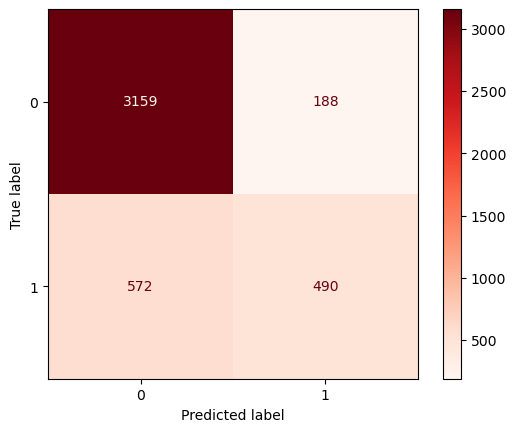

In [103]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=lr2.classes_)
disp.plot(cmap='Reds')

In [106]:
#Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2_proba)
roc_auc = roc_auc_score(y_test, y_pred_2_proba)

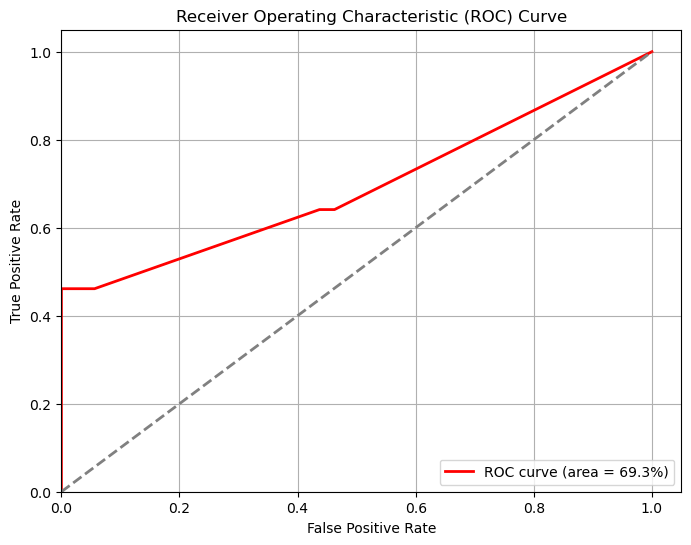

In [107]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.1%})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Model 3 - Log Reg with MFCC as sole input

### We flatten the observations of MFCC from a 2d array to a 1d series to feed into the model

In [108]:
flattened=[]

In [109]:
flattened_index=X_train.index

In [110]:
for j in X_train['mfcc']:
    flattened.append(np.array(j.flatten()))    

In [111]:
type(flattened)

list

In [112]:
print(len(flattened))

17185


In [113]:
X_train_3 = pd.Series(flattened, index=flattened_index)

In [114]:
X_train_3.shape

(17185,)

In [115]:
X_train_3[0].shape

(880,)

In [116]:
type(X_train_3[0])

numpy.ndarray

In [117]:
X_train_3 = np.stack(X_train_3.values)

In [118]:
X_train_3[0]

array([-4.94363190e+02, -3.14765869e+02, -2.56520905e+02, -2.48239212e+02,
       -2.53031876e+02, -2.55517334e+02, -2.48052017e+02, -2.32951981e+02,
       -2.19962173e+02, -1.42841690e+02, -9.73684616e+01, -1.10779991e+02,
       -1.32577957e+02, -1.74496826e+02, -2.58991180e+02, -2.96776947e+02,
       -2.27697571e+02, -1.72998871e+02, -1.91706116e+02, -2.18036591e+02,
       -2.23801773e+02, -2.41474701e+02, -2.48627243e+02, -2.24094589e+02,
       -2.06402664e+02, -2.12667801e+02, -2.53713226e+02, -2.99129425e+02,
       -2.24645386e+02, -1.94393921e+02, -2.14507462e+02, -1.99503799e+02,
       -1.75753983e+02, -1.97116699e+02, -2.48568222e+02, -2.64348511e+02,
       -2.66590698e+02, -2.86438263e+02, -2.94369110e+02, -2.90658600e+02,
       -2.94621582e+02, -2.69237000e+02, -1.65282639e+02, -1.53554474e+02,
        3.61295471e+01,  8.51948547e+01,  1.05760651e+02,  1.15315674e+02,
        1.16228172e+02,  1.17554886e+02,  1.22276215e+02,  1.27962784e+02,
        1.27946182e+02,  

In [119]:
flattened=[]

In [120]:
flattened_index=X_test.index

In [121]:
for j in X_test['mfcc']:
    flattened.append(np.array(j.flatten()))  

In [122]:
print(len(flattened))

4409


In [123]:
X_test_3 = pd.Series(flattened, index=flattened_index)

In [124]:
X_test_3 = np.stack(X_test_3.values)

In [125]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [126]:
scaler = StandardScaler()
X_train_3= scaler.fit_transform(X_train_3)
X_test_3 = scaler.transform(X_test_3)

In [127]:
lr3=LogisticRegression(multi_class='ovr', max_iter=10000, class_weight='balanced')
lr3.fit(X_train_3, y_train)

C:\Users\GGMachines_Gaming\.conda\envs\audio6\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr')

In [128]:
# Make predictions
y_pred_3 = lr3.predict(X_test_3)

In [129]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_3)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 81.45%


In [130]:
y_prob_3 = lr3.predict_proba(X_test_3)

In [131]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      3347
           1       0.58      0.84      0.69      1062

    accuracy                           0.81      4409
   macro avg       0.76      0.82      0.78      4409
weighted avg       0.85      0.81      0.82      4409



In [132]:
conf_matrix = confusion_matrix(y_test, y_pred_3)

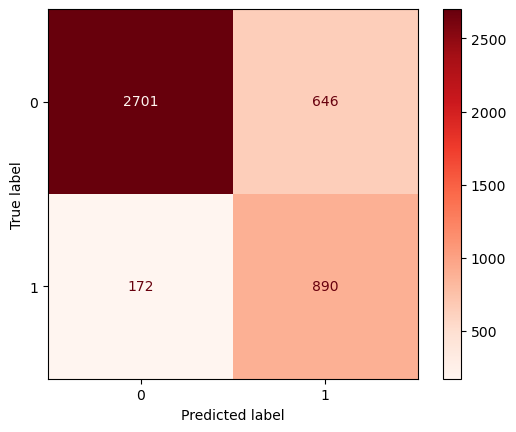

In [133]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=lr3.classes_)
disp.plot(cmap='Reds')

In [138]:
890+172

1062

In [139]:
y_pred_3_proba = lr3.predict_proba(X_test_3)[:, 1]

In [140]:
roc_auc = roc_auc_score(y_test, y_pred_3_proba)
print(f"ROC area under curve: {roc_auc:.2%}")

ROC area under curve: 89.70%


In [141]:
#Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_3_proba)
roc_auc = roc_auc_score(y_test, y_pred_3_proba)

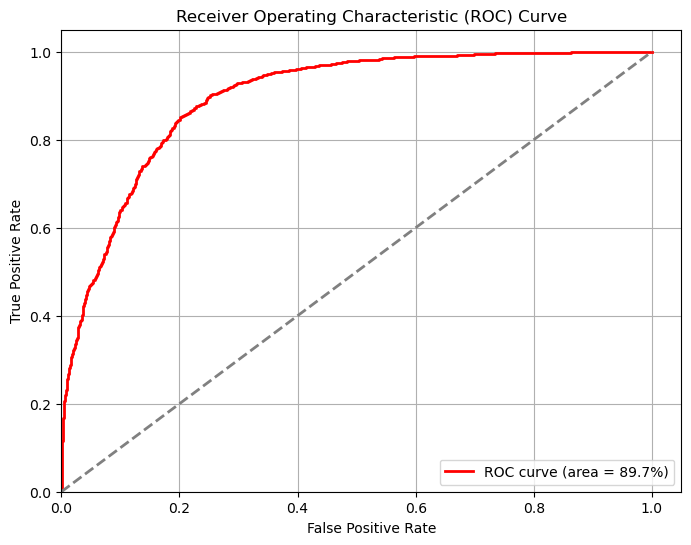

In [142]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.1%})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Model 4: Log Reg with MFCC plus age and genders as inputs

In [143]:
(X_train_3).shape

(17185, 880)

In [144]:
type(X_train_3)

numpy.ndarray

In [145]:
X_train_3[0].shape

(880,)

In [146]:
type(X_train_3[0])

numpy.ndarray

In [147]:
X_train_4=X_train_2.copy(deep=True)


In [148]:
X_test_4=X_test_2.copy(deep=True)

In [149]:
X_train_4['mfcc']=list(X_train_3)


In [150]:
X_test_4['mfcc']=list(X_test_3)


In [151]:
X_train_4

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-2.1700144, -0.6396421, 0.084675536, 0.180107..."
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.9328847, 0.85713893, 0.72290856, 0.5693297,..."
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.20208737, 0.61283255, 0.7978154, 0.8822933,..."
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-0.3180829, -0.5547933, -0.6473989, -0.421683..."
4,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.5363193, 0.38900366, 0.090073645, -0.134545..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[1.89035, 1.9323378, 1.7289041, 1.5921361, 1.5..."
17181,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[2.0232813, 2.0404756, 1.8939708, 1.6173787, 1..."
17182,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.52879786, 1.1999874, 1.4935962, 1.3567082, ..."
17183,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[2.1320195, 1.8202506, 1.4430757, 1.2739557, 1..."


In [152]:
X_test_4

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc
0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-2.7469566, -1.3463874, -0.5585381, -0.004435..."
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-1.283601, -1.4333568, -1.4675194, -0.9839787..."
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-0.36041316, -0.19908471, -0.24026617, -0.519..."
3,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-2.8348494, -3.3214445, -3.4807436, -3.430121..."
4,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[1.320025, 1.1548349, 0.848939, 0.92627734, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[1.5971184, 0.8166299, 0.32045707, 0.93322563,..."
4405,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-1.1211178, -1.1865022, -0.76184416, 0.026269..."
4406,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.559078, 0.411911, 0.12100457, -0.42071256, ..."
4407,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[2.310824, 1.8786781, 0.9649765, 0.5819706, 0...."


In [153]:
X_train_3

array([[-2.1700144 , -0.6396421 ,  0.08467554, ...,  0.0546077 ,
        -0.17189041,  0.07921192],
       [ 0.9328847 ,  0.85713893,  0.72290856, ...,  1.7942069 ,
         1.6581414 ,  2.060593  ],
       [ 0.20208737,  0.61283255,  0.7978154 , ..., -0.31603214,
        -0.8789009 , -0.5290683 ],
       ...,
       [ 0.52879786,  1.1999874 ,  1.4935962 , ...,  0.25245005,
        -1.0755854 , -0.85740525],
       [ 2.1320195 ,  1.8202506 ,  1.4430757 , ..., -0.3270971 ,
        -0.10911936, -0.05550599],
       [ 1.257546  ,  0.98044753,  0.5187464 , ..., -1.7542706 ,
        -1.3511143 , -0.54249203]], dtype=float32)

In [154]:
X_train_4['mfcc']=list(X_train_3)

In [155]:
X_train_4

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-2.1700144, -0.6396421, 0.084675536, 0.180107..."
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.9328847, 0.85713893, 0.72290856, 0.5693297,..."
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.20208737, 0.61283255, 0.7978154, 0.8822933,..."
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-0.3180829, -0.5547933, -0.6473989, -0.421683..."
4,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.5363193, 0.38900366, 0.090073645, -0.134545..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[1.89035, 1.9323378, 1.7289041, 1.5921361, 1.5..."
17181,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[2.0232813, 2.0404756, 1.8939708, 1.6173787, 1..."
17182,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.52879786, 1.1999874, 1.4935962, 1.3567082, ..."
17183,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[2.1320195, 1.8202506, 1.4430757, 1.2739557, 1..."


In [156]:
X_train_4.iloc[0,16].shape

(880,)

In [157]:
X_train_4.iloc[0,16]

array([-2.17001438e+00, -6.39642119e-01,  8.46755356e-02,  1.80107981e-01,
        1.13972120e-01,  7.70114660e-02,  1.61688581e-01,  3.44087660e-01,
        5.07693827e-01,  1.48930717e+00,  2.06846476e+00,  1.89031160e+00,
        1.60788882e+00,  1.07478404e+00,  5.76215331e-03, -4.73168105e-01,
        4.02004421e-01,  1.09246898e+00,  8.60032439e-01,  5.29055774e-01,
        4.59801525e-01,  2.35865727e-01,  1.45224780e-01,  4.59795624e-01,
        6.82476938e-01,  5.96771836e-01,  7.85993487e-02, -4.89017576e-01,
        4.70114797e-01,  8.61607671e-01,  6.03641748e-01,  7.93657064e-01,
        1.09077084e+00,  8.18092108e-01,  1.65190428e-01, -3.78815308e-02,
       -6.74629733e-02, -3.15667540e-01, -4.09257770e-01, -3.58693004e-01,
       -4.07005757e-01, -8.01379159e-02,  1.17125010e+00,  1.44222748e+00,
       -1.83482468e+00, -7.31757283e-01, -2.56887168e-01, -1.89276896e-02,
       -8.40411463e-04,  2.40996052e-02,  1.37409270e-01,  2.74627805e-01,
        2.75486171e-01, -

In [158]:
print(y_train.shape)
print(X_train_4.shape)

(17185,)
(17185, 17)


In [159]:
print(X_train_4.dtypes)

F         bool
M         bool
15        bool
16        bool
20        bool
25        bool
30        bool
35        bool
40        bool
45        bool
50        bool
55        bool
60        bool
65        bool
70        bool
80        bool
mfcc    object
dtype: object


In [160]:
train_df['mfcc'][0].shape

(20, 44)

In [161]:
train_df['mfcc'][17150].shape

(20, 44)

In [162]:
train_df['mfcc'][0][0].shape

(44,)

In [163]:
train_df['mfcc'][0][0]

array([-494.3632 , -314.76587, -256.5209 , -248.23921, -253.03188,
       -255.51733, -248.05202, -232.95198, -219.96217, -142.84169,
        -97.36846, -110.77999, -132.57796, -174.49683, -258.99118,
       -296.77695, -227.69757, -172.99887, -191.70612, -218.03659,
       -223.80177, -241.4747 , -248.62724, -224.09459, -206.40266,
       -212.6678 , -253.71323, -299.12943, -224.64539, -194.39392,
       -214.50746, -199.5038 , -175.75398, -197.1167 , -248.56822,
       -264.3485 , -266.5907 , -286.43826, -294.3691 , -290.6586 ,
       -294.62158, -269.237  , -165.28264, -153.55447], dtype=float32)

In [164]:
X_test_4

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc
0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-2.7469566, -1.3463874, -0.5585381, -0.004435..."
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-1.283601, -1.4333568, -1.4675194, -0.9839787..."
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-0.36041316, -0.19908471, -0.24026617, -0.519..."
3,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-2.8348494, -3.3214445, -3.4807436, -3.430121..."
4,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[1.320025, 1.1548349, 0.848939, 0.92627734, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[1.5971184, 0.8166299, 0.32045707, 0.93322563,..."
4405,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-1.1211178, -1.1865022, -0.76184416, 0.026269..."
4406,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[0.559078, 0.411911, 0.12100457, -0.42071256, ..."
4407,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[2.310824, 1.8786781, 0.9649765, 0.5819706, 0...."


In [165]:
# Assuming 'C' is the column with arrays of shape (880,)
arrays_col = pd.DataFrame(X_test_4['mfcc'].tolist(), index=X_test_4.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_test_4 = X_test_4.drop(columns=['mfcc']).join(arrays_col)

In [166]:
# Assuming 'C' is the column with arrays of shape (880,)
arrays_col = pd.DataFrame(X_train_4['mfcc'].tolist(), index=X_train_4.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_train_4 = X_train_4.drop(columns=['mfcc']).join(arrays_col)


In [167]:
X_train_4.shape

(17185, 896)

In [168]:
X_test_4.shape

(4409, 896)

In [169]:
lr4=LogisticRegression(multi_class='ovr', max_iter=10000, class_weight='balanced')
lr4.fit(X_train_4, y_train)

C:\Users\GGMachines_Gaming\.conda\envs\audio6\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr')

In [170]:
# Make predictions
y_pred_4= lr4.predict(X_test_4)

In [171]:
y_pred_4_proba = lr4.predict_proba(X_test_4)[:, 1]

In [172]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_4)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 83.96%


In [173]:
y_prob_4 = lr4.predict_proba(X_test_4)

In [174]:
print(classification_report(y_test, y_pred_4))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      3347
           1       0.62      0.85      0.72      1062

    accuracy                           0.84      4409
   macro avg       0.78      0.84      0.80      4409
weighted avg       0.87      0.84      0.85      4409



In [175]:
conf_matrix = confusion_matrix(y_test, y_pred_4)

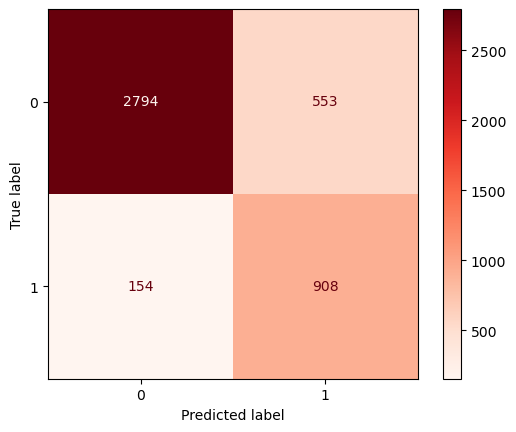

In [176]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=lr4.classes_)
disp.plot(cmap='Reds')

In [177]:
y_pred_4_proba = lr4.predict_proba(X_test_4)[:, 1]

In [178]:
roc_auc = roc_auc_score(y_test, y_pred_4_proba)
print(f"ROC area under curve: {roc_auc:.2%}")

ROC area under curve: 91.56%


In [179]:
#Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_4_proba)
roc_auc = roc_auc_score(y_test, y_pred_4_proba)

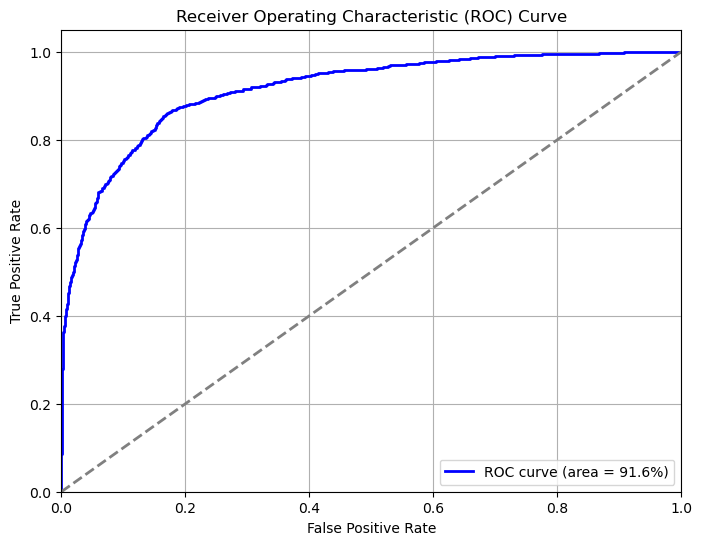

In [180]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.1%})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Model 5: MFCC_delta plus age and genders as inputs

In [181]:
X_train_2

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
17181,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
17182,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
17183,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [182]:
def preprocess_features(feature: str ='mfcc_delta', input: pd.DataFrame =X_train, output: pd.DataFrame ='X_train_5', ): 
    flattened=[]
    flattened_index=input.index
    for j in input[feature]:
        flattened.append(np.array(j.flatten()))
    print(len(flattened))
    output = pd.Series(flattened, index=flattened_index)
    output = np.stack(output.values)
    return output

In [183]:
train_features = preprocess_features(feature="mfcc_delta", input=X_train,output='train_features')

17185


In [184]:
test_features = preprocess_features(feature="mfcc_delta", input=X_test,output='test_features')

4409


In [185]:
X_train_5 = X_train_2.copy(deep=True)

In [186]:
X_test_5 = X_test_2.copy(deep=True)

In [187]:
X_train_5['mfcc_delta']=list(train_features)


In [188]:
X_test_5['mfcc_delta']=list(test_features)


In [189]:
X_train_5

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc_delta
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[22.54509, 22.54509, 22.54509, 22.54509, 22.54..."
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[1.7263998, 1.7263998, 1.7263998, 1.7263998, 1..."
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[7.1880474, 7.1880474, 7.1880474, 7.1880474, 7..."
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[9.711183, 9.711183, 9.711183, 9.711183, 9.711..."
4,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[15.645952, 15.645952, 15.645952, 15.645952, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-18.052214, -18.052214, -18.052214, -18.05221..."
17181,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-12.304473, -12.304473, -12.304473, -12.30447..."
17182,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[6.8850102, 6.8850102, 6.8850102, 6.8850102, 6..."
17183,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-3.5998185, -3.5998185, -3.5998185, -3.599818..."


In [190]:
X_test_5

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc_delta
0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[41.07573, 41.07573, 41.07573, 41.07573, 41.07..."
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[28.788923, 28.788923, 28.788923, 28.788923, 2..."
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[12.734898, 12.734898, 12.734898, 12.734898, 1..."
3,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[5.905793, 5.905793, 5.905793, 5.905793, 5.905..."
4,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-0.2873291, -0.2873291, -0.2873291, -0.287329..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-2.5700252, -2.5700252, -2.5700252, -2.570025..."
4405,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[28.721848, 28.721848, 28.721848, 28.721848, 2..."
4406,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-16.838709, -16.838709, -16.838709, -16.83870..."
4407,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-17.856054, -17.856054, -17.856054, -17.85605..."


In [191]:
X_test_5.columns

Index(['F', 'M', '15', '16', '20', '25', '30', '35', '40', '45', '50', '55',
       '60', '65', '70', '80', 'mfcc_delta'],
      dtype='object')

In [192]:
arrays_col = pd.DataFrame(X_test_5['mfcc_delta'].tolist(), index=X_test_5.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_test_5 = X_test_5.drop(columns=['mfcc_delta']).join(arrays_col)

In [193]:
arrays_col = pd.DataFrame(X_train_5['mfcc_delta'].tolist(), index=X_train_5.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_train_5 = X_train_5.drop(columns=['mfcc_delta']).join(arrays_col)


In [194]:
X_train_5.shape

(17185, 896)

In [195]:
X_test_5.shape

(4409, 896)

In [196]:
scaler = StandardScaler()
X_train_5 = scaler.fit_transform(X_train_5)
X_test_5 = scaler.transform(X_test_5)

In [197]:
lr5=LogisticRegression(multi_class='ovr', max_iter=10000, class_weight='balanced')
lr5.fit(X_train_5, y_train)

C:\Users\GGMachines_Gaming\.conda\envs\audio6\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr')

In [198]:
# Make predictions
y_pred_5= lr5.predict(X_test_5)

In [199]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 72.13%


In [200]:
y_prob_5 = lr5.predict_proba(X_test_5)

In [201]:
print(classification_report(y_test, y_pred_5))

              precision    recall  f1-score   support

           0       0.86      0.76      0.80      3347
           1       0.44      0.61      0.51      1062

    accuracy                           0.72      4409
   macro avg       0.65      0.68      0.66      4409
weighted avg       0.76      0.72      0.73      4409



In [202]:
conf_matrix = confusion_matrix(y_test, y_pred_5)

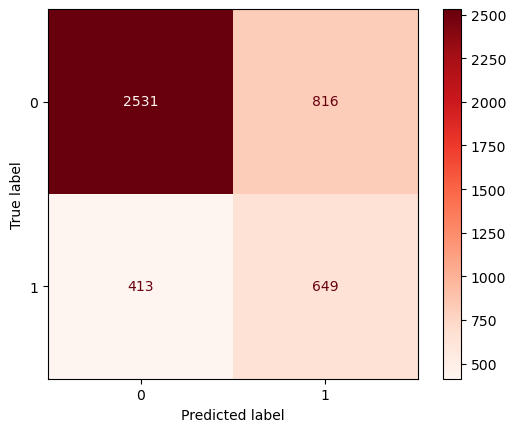

In [203]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=lr5.classes_)
disp.plot(cmap='Reds')

In [204]:
y_pred_5_proba = lr5.predict_proba(X_test_5)[:, 1]

In [205]:
roc_auc = roc_auc_score(y_test, y_pred_5_proba)
print(f"ROC area under curve: {roc_auc:.2%}")

ROC area under curve: 75.95%


In [206]:
#Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_5_proba)
roc_auc = roc_auc_score(y_test, y_pred_5_proba)

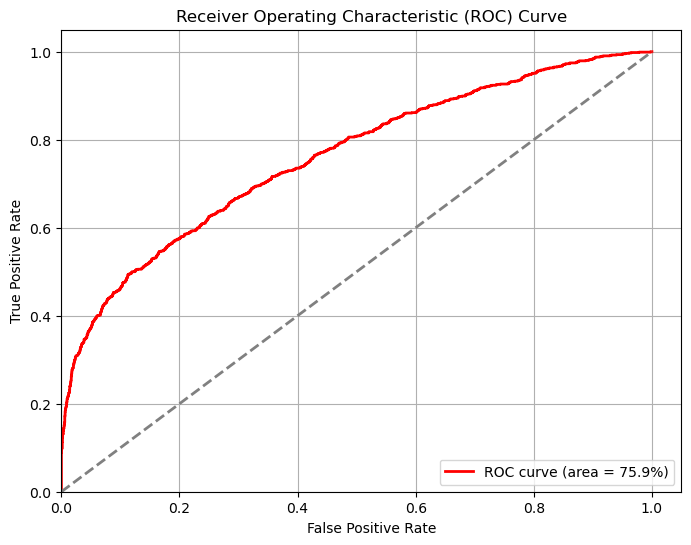

In [207]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.1%})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Model 6: Log Reg of MFCC_delta_2 plus age and genders as inputs

In [208]:
train_features = preprocess_features(feature="mfcc_delta_2", input=X_train,output='train_features')

17185


In [209]:
test_features = preprocess_features(feature="mfcc_delta_2", input=X_test,output='test_features')

4409


In [210]:
X_train_6 = X_train_2.copy(deep=True)

In [211]:
X_train_6

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
17181,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
17182,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
17183,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [212]:
X_test_6 = X_test_2.copy(deep=True)

In [213]:
X_test_6

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4405,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4406,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4407,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [214]:
X_train_6['mfcc_delta_2']=list(train_features)


In [215]:
X_test_6['mfcc_delta_2']=list(test_features)


In [216]:
X_train_6

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc_delta_2
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-13.363751, -13.363751, -13.363751, -13.36375..."
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[8.442614, 8.442614, 8.442614, 8.442614, 8.442..."
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-7.412616, -7.412616, -7.412616, -7.412616, -..."
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-0.45292982, -0.45292982, -0.45292982, -0.452..."
4,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[11.970617, 11.970617, 11.970617, 11.970617, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-4.0458364, -4.0458364, -4.0458364, -4.045836..."
17181,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[1.0900352, 1.0900352, 1.0900352, 1.0900352, 1..."
17182,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-6.6832395, -6.6832395, -6.6832395, -6.683239..."
17183,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[2.0841863, 2.0841863, 2.0841863, 2.0841863, 2..."


In [217]:
X_train_6.columns

Index(['F', 'M', '15', '16', '20', '25', '30', '35', '40', '45', '50', '55',
       '60', '65', '70', '80', 'mfcc_delta_2'],
      dtype='object')

In [218]:
X_test_6

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80,mfcc_delta_2
0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-26.089209, -26.089209, -26.089209, -26.08920..."
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[-4.8265953, -4.8265953, -4.8265953, -4.826595..."
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[8.222871, 8.222871, 8.222871, 8.222871, 8.222..."
3,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[1.4573967, 1.4573967, 1.4573967, 1.4573967, 1..."
4,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,"[3.1170475, 3.1170475, 3.1170475, 3.1170475, 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[3.2941802, 3.2941802, 3.2941802, 3.2941802, 3..."
4405,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[-13.984404, -13.984404, -13.984404, -13.98440..."
4406,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[1.6615343, 1.6615343, 1.6615343, 1.6615343, 1..."
4407,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,"[7.567294, 7.567294, 7.567294, 7.567294, 7.567..."


In [219]:
X_test_6.shape

(4409, 17)

In [220]:
X_test_6.columns

Index(['F', 'M', '15', '16', '20', '25', '30', '35', '40', '45', '50', '55',
       '60', '65', '70', '80', 'mfcc_delta_2'],
      dtype='object')

In [221]:
arrays_col = pd.DataFrame(X_train_6['mfcc_delta_2'].tolist(), index=X_train_6.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_train_6 = X_train_6.drop(columns=['mfcc_delta_2']).join(arrays_col)


In [222]:
arrays_col = pd.DataFrame(X_test_6['mfcc_delta_2'].tolist(), index=X_test_6.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_test_6 = X_test_6.drop(columns=['mfcc_delta_2']).join(arrays_col)

In [223]:
X_train_6 = scaler.fit_transform(X_train_6)
X_test_6 = scaler.fit_transform(X_test_6)

In [224]:
X_train_6.shape

(17185, 896)

In [225]:
X_test_6.shape

(4409, 896)

In [226]:
lr6=LogisticRegression(multi_class='ovr', max_iter=10000, class_weight='balanced')
lr6.fit(X_train_6, y_train)

C:\Users\GGMachines_Gaming\.conda\envs\audio6\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr')

In [227]:
# Make predictions
y_pred_6= lr6.predict(X_test_6)

In [228]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_6)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 68.95%


In [229]:
y_prob_6 = lr6.predict_proba(X_test_6)

In [230]:
print(classification_report(y_test, y_pred_6))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      3347
           1       0.41      0.68      0.51      1062

    accuracy                           0.69      4409
   macro avg       0.64      0.69      0.64      4409
weighted avg       0.76      0.69      0.71      4409



In [231]:
conf_matrix = confusion_matrix(y_test, y_pred_6)

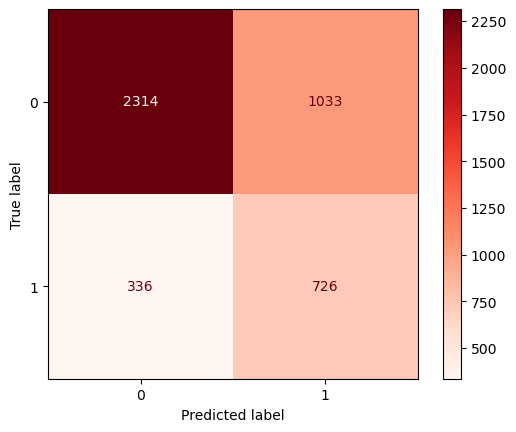

In [232]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=lr6.classes_)
disp.plot(cmap='Reds')

In [233]:
y_pred_6_proba = lr6.predict_proba(X_test_6)[:, 1]

In [236]:
roc_auc = roc_auc_score(y_test, y_pred_6_proba)
print(f"ROC area under curve: {roc_auc:.2%}")

ROC area under curve: 76.04%


In [237]:
#Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_6_proba)
roc_auc = roc_auc_score(y_test, y_pred_6_proba)

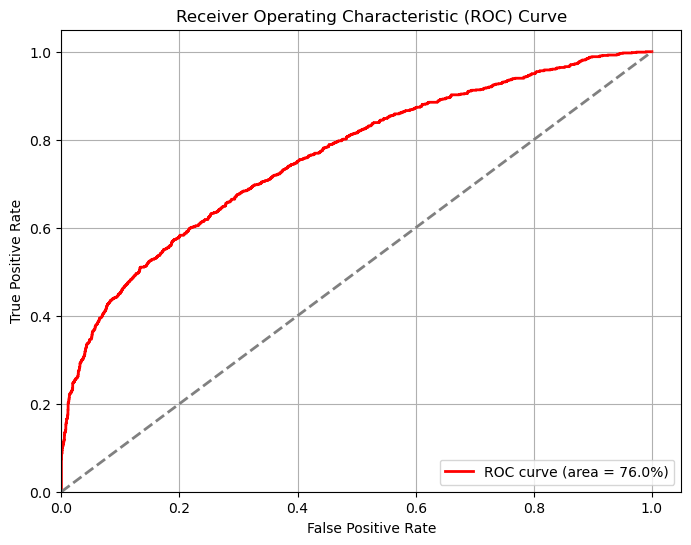

In [238]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.1%})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Model 7: Log Reg of locations against all features

In [239]:
X_train_2[0:3]

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [240]:
X_train_3.shape

(17185, 880)

In [241]:
X_train_7=X_train_2.copy(deep=True) 
X_train_7[0:4]

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [242]:
X_test_7=X_test_2.copy(deep=True) 
X_test_7[0:4]

,F,M,15,16,20,25,30,35,40,45,50,55,60,65,70,80
0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [243]:
def preprocess_features(feature: str ='mfcc_delta', input: pd.DataFrame =X_train, output: pd.DataFrame ='X_train_5', ): 
    flattened=[]
    flattened_index=input.index
    for j in input[feature]:
        flattened.append(np.array(j.flatten()))
    print(len(flattened))
    output = pd.Series(flattened, index=flattened_index)
    output = np.stack(output.values)
    return output

In [244]:
X_train['mfcc'][0:3]

0    [[-494.3632, -314.76587, -256.5209, -248.23921...
1    [[-200.87267, -189.22813, -205.93425, -217.350...
2    [[-269.9958, -209.71855, -199.9971, -192.51334...
Name: mfcc, dtype: object

In [245]:
mfcc_train=preprocess_features(feature='mfcc',input=X_train,output='mfcc_train')

17185


In [246]:
mfcc_train.shape

(17185, 880)

In [247]:
mfcc_test=preprocess_features(feature='mfcc',input=X_test,output='mfcc_test')

4409


In [248]:
X_train_7['mfcc']=list(mfcc_train)

In [249]:
X_train_7['mfcc'][0].shape

(880,)

In [250]:
X_test_7['mfcc']=list(mfcc_test)

In [251]:
X_test_7['mfcc'][0].shape

(880,)

In [252]:
arrays_col = pd.DataFrame(X_train_7['mfcc'].tolist(), index=X_train_7.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_train_7 = X_train_7.drop(columns=['mfcc']).join(arrays_col)

In [253]:
arrays_col = pd.DataFrame(X_test_7['mfcc'].tolist(), index=X_test_7.index)
arrays_col.columns = [f'C_{i}' for i in range(arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_test_7 = X_test_7.drop(columns=['mfcc']).join(arrays_col)

In [254]:
X_test_7.shape

(4409, 896)

In [255]:
X_train_7[0:3]

,F,M,15,16,20,25,30,35,40,45,...,C_870,C_871,C_872,C_873,C_874,C_875,C_876,C_877,C_878,C_879
0,True,False,False,False,True,False,False,False,False,False,...,-0.629049,-0.686690,0.020880,-3.906036,-1.348402,-0.311579,-0.675096,-1.603763,-3.112424,-1.567949
1,True,False,False,False,True,False,False,False,False,False,...,-1.296468,-0.774035,-0.488879,-3.432156,1.849553,10.295572,14.280432,9.282236,8.045408,10.696609
2,True,False,False,False,True,False,False,False,False,False,...,-2.957449,-4.200583,-2.480897,4.125443,9.639858,7.118150,0.698773,-3.923139,-7.423116,-5.333145


In [256]:
X_test_7[0:3]

,F,M,15,16,20,25,30,35,40,45,...,C_870,C_871,C_872,C_873,C_874,C_875,C_876,C_877,C_878,C_879
0,False,True,False,False,False,False,False,False,True,False,...,-2.645841,-12.323847,-7.981042,-8.828581,-7.590025,-8.760853,-8.547211,-5.661369,-1.133327,5.415093
1,False,True,False,False,False,False,False,False,True,False,...,3.673773,2.227298,-1.303778,0.433277,5.380218,12.999774,8.371944,10.110106,12.973080,8.912657
2,False,True,False,False,False,False,False,False,True,False,...,0.637181,0.499459,-4.268327,-2.127909,2.294528,-0.389651,-2.834422,-2.580247,2.188254,1.707927


In [257]:
mfcc_train=preprocess_features(feature='mfcc_delta',input=X_train,output='mfcc_delta_train')

17185


In [258]:
mfcc_train.shape

(17185, 880)

In [259]:
mfcc_test=preprocess_features(feature='mfcc_delta',input=X_test,output='mfcc_delta_test')

4409


In [260]:
X_train_7['mfcc_delta']=list(mfcc_train)

In [261]:
X_train_7['mfcc_delta'][0].shape

(880,)

In [262]:
X_test_7['mfcc_delta']=list(mfcc_test)

In [263]:
X_test_7['mfcc_delta'][0].shape

(880,)

In [264]:
arrays_col = pd.DataFrame(X_train_7['mfcc_delta'].tolist(), index=X_train_7.index)
arrays_col.columns = [f'C_{i}' for i in range(1000,1000+arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_train_7 = X_train_7.drop(columns=['mfcc_delta']).join(arrays_col)

In [265]:
X_train_7[0:3]

,F,M,15,16,20,25,30,35,40,45,...,C_1870,C_1871,C_1872,C_1873,C_1874,C_1875,C_1876,C_1877,C_1878,C_1879
0,True,False,False,False,True,False,False,False,False,False,...,0.166245,0.218161,0.032682,-0.189150,-0.174704,-0.127452,-0.127452,-0.127452,-0.127452,-0.127452
1,True,False,False,False,True,False,False,False,False,False,...,-0.437760,0.244896,1.234125,1.896276,1.846711,1.822418,1.822418,1.822418,1.822418,1.822418
2,True,False,False,False,True,False,False,False,False,False,...,1.052623,1.862725,1.665134,0.868114,-0.127971,-0.739919,-0.739919,-0.739919,-0.739919,-0.739919


In [266]:
arrays_col = pd.DataFrame(X_test_7['mfcc_delta'].tolist(), index=X_test_7.index)
arrays_col.columns = [f'C_{i}' for i in range(1000,1000+arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_test_7 = X_test_7.drop(columns=['mfcc_delta']).join(arrays_col)

In [267]:
X_test_7[0:3]

,F,M,15,16,20,25,30,35,40,45,...,C_1870,C_1871,C_1872,C_1873,C_1874,C_1875,C_1876,C_1877,C_1878,C_1879
0,False,True,False,False,False,False,False,False,True,False,...,-1.955916,-1.586848,-1.507542,-0.742742,0.416215,1.614602,1.614602,1.614602,1.614602,1.614602
1,False,True,False,False,False,False,False,False,True,False,...,0.577169,1.612210,1.675315,1.527280,1.546060,1.531957,1.531957,1.531957,1.531957,1.531957
2,False,True,False,False,False,False,False,False,True,False,...,-0.372867,-0.503129,-0.671043,-0.509195,0.026187,0.302833,0.302833,0.302833,0.302833,0.302833


In [268]:
X_train.columns

Index(['mfcc', 'mfcc_delta', 'mfcc_delta_2', 'recording num', 'F', 'M', '15',
       '16', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70',
       '80'],
      dtype='object')

In [269]:
mfcc_train=preprocess_features(feature='mfcc_delta_2',input=X_train,output='mfcc_delta_2_train')

17185


In [270]:
mfcc_train.shape

(17185, 880)

In [271]:
mfcc_test=preprocess_features(feature='mfcc_delta_2',input=X_test,output='mfcc_delta_2_test')

4409


In [272]:
mfcc_test.shape

(4409, 880)

In [273]:
X_train_7['mfcc_delta_2']=list(mfcc_train)

In [274]:
X_train_7['mfcc_delta_2'][0].shape

(880,)

In [275]:
X_test_7['mfcc_delta_2']=list(mfcc_test)

In [276]:
X_test_7['mfcc_delta_2'][0].shape

(880,)

In [277]:
arrays_col = pd.DataFrame(X_train_7['mfcc_delta_2'].tolist(), index=X_train_7.index)
arrays_col.columns = [f'C_{i}' for i in range(2000,2000+arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_train_7 = X_train_7.drop(columns=['mfcc_delta_2']).join(arrays_col)

In [278]:
#X_test_7=X_test_7.drop(columns=['mfcc_delta'])

In [279]:
X_test_7[0:3]

,F,M,15,16,20,25,30,35,40,45,...,C_1871,C_1872,C_1873,C_1874,C_1875,C_1876,C_1877,C_1878,C_1879,mfcc_delta_2
0,False,True,False,False,False,False,False,False,True,False,...,-1.586848,-1.507542,-0.742742,0.416215,1.614602,1.614602,1.614602,1.614602,1.614602,"[-26.089209, -26.089209, -26.089209, -26.08920..."
1,False,True,False,False,False,False,False,False,True,False,...,1.612210,1.675315,1.527280,1.546060,1.531957,1.531957,1.531957,1.531957,1.531957,"[-4.8265953, -4.8265953, -4.8265953, -4.826595..."
2,False,True,False,False,False,False,False,False,True,False,...,-0.503129,-0.671043,-0.509195,0.026187,0.302833,0.302833,0.302833,0.302833,0.302833,"[8.222871, 8.222871, 8.222871, 8.222871, 8.222..."


In [280]:
arrays_col = pd.DataFrame(X_test_7['mfcc_delta_2'].tolist(), index=X_test_7.index)
arrays_col.columns = [f'C_{i}' for i in range(2000,2000+arrays_col.shape[1])]

# Drop the original column and concatenate the expanded columns
X_test_7 = X_test_7.drop(columns=['mfcc_delta_2']).join(arrays_col)

In [281]:
X_test_7[0:3]

,F,M,15,16,20,25,30,35,40,45,...,C_2870,C_2871,C_2872,C_2873,C_2874,C_2875,C_2876,C_2877,C_2878,C_2879
0,False,True,False,False,False,False,False,False,True,False,...,0.291591,0.398001,0.918843,0.985306,0.760463,0.667152,0.667152,0.667152,0.667152,0.667152
1,False,True,False,False,False,False,False,False,True,False,...,0.381862,0.438054,0.173141,0.228379,0.346238,-0.399406,-0.399406,-0.399406,-0.399406,-0.399406
2,False,True,False,False,False,False,False,False,True,False,...,-0.048498,0.252915,0.336593,0.194395,0.256010,0.220525,0.220525,0.220525,0.220525,0.220525


In [282]:
X_train_7 = scaler.fit_transform(X_train_7)
X_test_7 = scaler.fit_transform(X_test_7)

In [283]:
lr7=LogisticRegression(multi_class='ovr', max_iter=10000, class_weight='balanced')
lr7.fit(X_train_7, y_train)

C:\Users\GGMachines_Gaming\.conda\envs\audio6\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr')

In [284]:
# Make predictions
y_pred_7= lr7.predict(X_test_7)

In [285]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_7)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 81.58%


In [286]:
y_prob_7 = lr7.predict_proba(X_test_7)

In [287]:
print(classification_report(y_test, y_pred_7))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      3347
           1       0.58      0.87      0.70      1062

    accuracy                           0.82      4409
   macro avg       0.77      0.84      0.78      4409
weighted avg       0.86      0.82      0.83      4409



In [288]:
conf_matrix = confusion_matrix(y_test, y_pred_7)

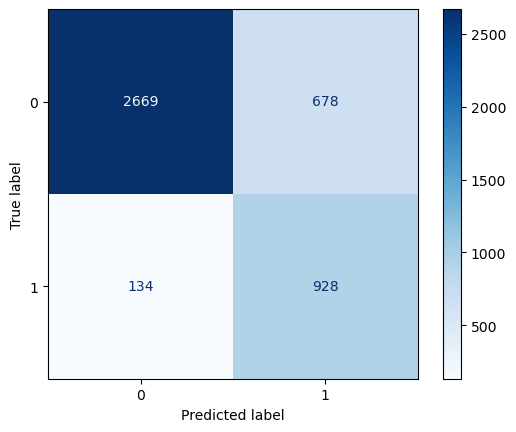

In [289]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=lr7.classes_)
disp.plot(cmap='Blues')

In [291]:
y_pred_7_proba = lr7.predict_proba(X_test_7)[:, 1]

In [292]:
roc_auc = roc_auc_score(y_test, y_pred_7_proba)
print(f"ROC area under curve: {roc_auc:.2%}")

ROC area under curve: 91.36%


In [293]:
#Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_7_proba)
roc_auc = roc_auc_score(y_test, y_pred_7_proba)

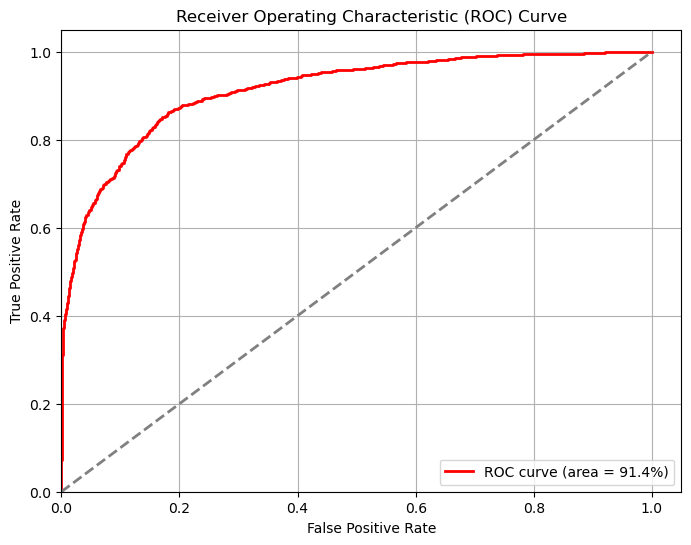

In [294]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.1%})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Model 8: k Means on MFCC

In [295]:
all_df.shape

(21594, 19)

In [296]:
X_train_3

array([[-2.1700144 , -0.6396421 ,  0.08467554, ...,  0.0546077 ,
        -0.17189041,  0.07921192],
       [ 0.9328847 ,  0.85713893,  0.72290856, ...,  1.7942069 ,
         1.6581414 ,  2.060593  ],
       [ 0.20208737,  0.61283255,  0.7978154 , ..., -0.31603214,
        -0.8789009 , -0.5290683 ],
       ...,
       [ 0.52879786,  1.1999874 ,  1.4935962 , ...,  0.25245005,
        -1.0755854 , -0.85740525],
       [ 2.1320195 ,  1.8202506 ,  1.4430757 , ..., -0.3270971 ,
        -0.10911936, -0.05550599],
       [ 1.257546  ,  0.98044753,  0.5187464 , ..., -1.7542706 ,
        -1.3511143 , -0.54249203]], dtype=float32)

In [297]:
X_test_3

array([[-2.7469566 , -1.3463874 , -0.5585381 , ..., -0.593804  ,
         0.15270752,  1.2073462 ],
       [-1.283601  , -1.4333568 , -1.4675194 , ...,  1.9265016 ,
         2.4663446 ,  1.7723893 ],
       [-0.36041316, -0.19908471, -0.24026617, ..., -0.10143597,
         0.6974908 ,  0.6084409 ],
       ...,
       [ 0.559078  ,  0.411911  ,  0.12100457, ..., -1.4085714 ,
        -1.789785  , -0.6984043 ],
       [ 2.310824  ,  1.8786781 ,  0.9649765 , ...,  0.5711962 ,
         0.33729178,  0.66352147],
       [-1.4966244 , -1.4323736 , -1.14162   , ..., -0.17302431,
         0.36838716,  0.5003277 ]], dtype=float32)

In [298]:
X_train_3_scaled = X_train_3
X_test_3_scaled = X_test_3

In [299]:
scaler = StandardScaler()   
X_train_3_scaled = scaler.fit_transform(X_train_3)
X_test_3_scaled = scaler.transform(X_test_3)

In [300]:
from sklearn.cluster import KMeans

In [301]:
n_clusters=3

In [302]:
# Fit K-Means on the training data for MFCC only inputs
kmeans = KMeans(n_clusters=n_clusters, random_state=2)  
kmeans.fit(X_train_3_scaled)

KMeans(n_clusters=3, random_state=2)

In [303]:
# Predict clusters for training and testing data
train_clusters = kmeans.predict(X_train_3_scaled)
test_clusters = kmeans.predict(X_test_3_scaled)

In [304]:
color_palette = sns.color_palette("Set2", n_colors=n_clusters)
dot_size=20

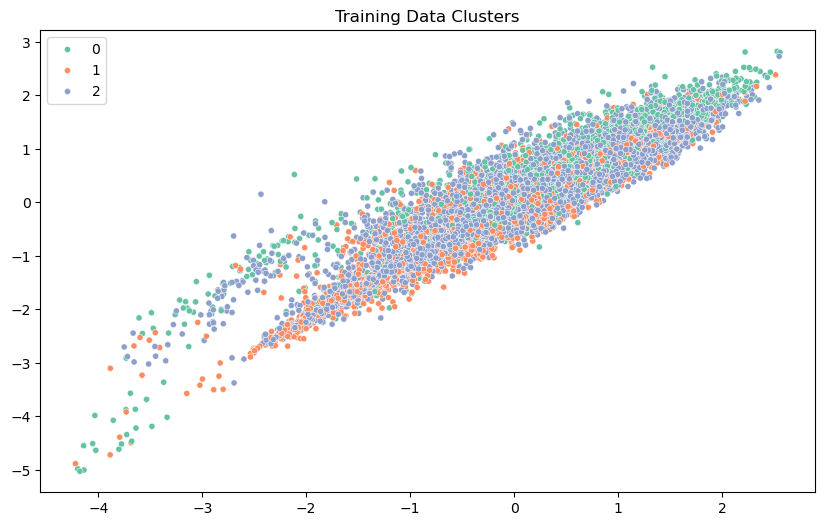

In [305]:
# Training data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_3_scaled[:, 0], y=X_train_3_scaled[:, 1], hue=train_clusters, palette=color_palette, s=dot_size)
plt.title('Training Data Clusters')
plt.show()

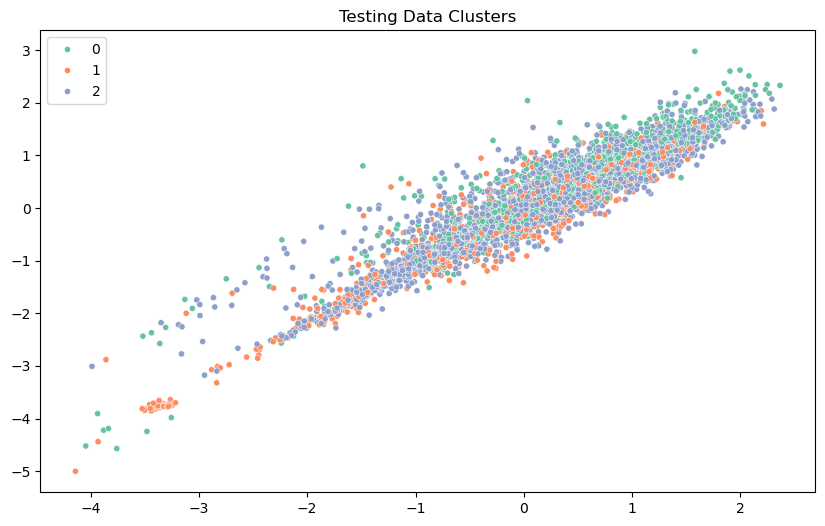

In [306]:
# Testing data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_3_scaled[:, 0], y=X_test_3_scaled[:, 1], hue=test_clusters, palette=color_palette,s=dot_size)
plt.title('Testing Data Clusters')
plt.show()

In [307]:
n_clusters=2

In [308]:
# Fit K-Means on the training data for MFCC only inputs
kmeans = KMeans(n_clusters=n_clusters, random_state=2)  
kmeans.fit(X_train_3_scaled)

KMeans(n_clusters=2, random_state=2)

In [309]:
# Predict clusters for training and testing data
train_clusters = kmeans.predict(X_train_3_scaled)
test_clusters = kmeans.predict(X_test_3_scaled)

In [310]:
color_palette = sns.color_palette("Set2", n_colors=n_clusters)
dot_size=20

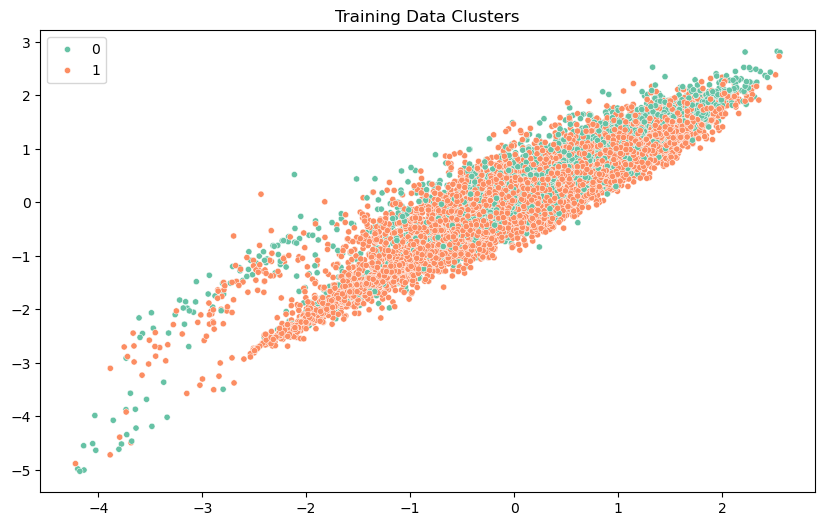

In [311]:
# Training data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_3_scaled[:, 0], y=X_train_3_scaled[:, 1], hue=train_clusters, palette=color_palette, s=dot_size)
plt.title('Training Data Clusters')
plt.show()

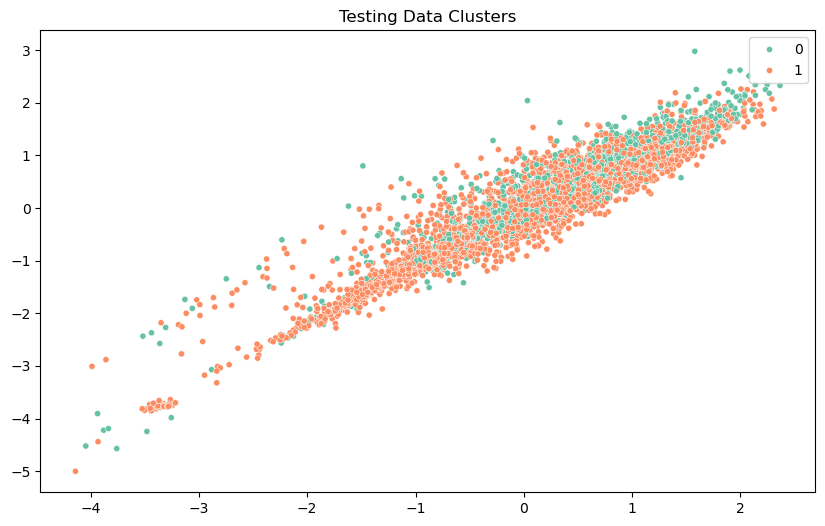

In [312]:
# Testing data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_3_scaled[:, 0], y=X_test_3_scaled[:, 1], hue=test_clusters, palette=color_palette,s=dot_size)
plt.title('Testing Data Clusters')
plt.show()

## Model 9: k Means on MFCC, gender and age

In [313]:
X_train_4

,F,M,15,16,20,25,30,35,40,45,...,C_870,C_871,C_872,C_873,C_874,C_875,C_876,C_877,C_878,C_879
0,True,False,False,False,True,False,False,False,False,False,...,0.200309,0.190688,0.313367,-0.300150,0.106524,0.270811,0.212452,0.054608,-0.171890,0.079212
1,True,False,False,False,True,False,False,False,False,False,...,0.095138,0.177002,0.233279,-0.226011,0.609256,1.950751,2.600539,1.794207,1.658141,2.060593
2,True,False,False,False,True,False,False,False,False,False,...,-0.166598,-0.359882,-0.079683,0.956381,1.833928,1.447517,0.431830,-0.316032,-0.878901,-0.529068
3,True,False,False,False,True,False,False,False,False,False,...,0.561890,0.306286,0.540024,1.203767,1.591140,1.570653,1.557865,1.399316,1.617327,1.177490
4,True,False,False,False,True,False,False,False,False,False,...,0.233724,1.343828,2.188498,1.312766,-0.192762,-0.447011,0.122434,1.837688,2.307185,1.578520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17180,True,False,False,False,True,False,False,False,False,False,...,0.723240,-1.146101,-1.127460,-0.584157,-0.543973,0.285944,-0.104638,0.504271,-0.751788,-1.259927
17181,True,False,False,False,True,False,False,False,False,False,...,-0.342708,-0.163204,-0.886519,-1.919662,-2.281600,-2.099148,-0.268021,-0.323817,-0.772401,-0.764888
17182,True,False,False,False,True,False,False,False,False,False,...,0.808327,0.153718,-0.478390,-1.156961,0.008075,0.444061,0.367224,0.252450,-1.075585,-0.857405
17183,True,False,False,False,True,False,False,False,False,False,...,-1.321447,-1.204890,-0.860614,-0.430411,-0.719024,-0.664826,-1.167095,-0.327097,-0.109119,-0.055506


In [314]:
X_test_4

,F,M,15,16,20,25,30,35,40,45,...,C_870,C_871,C_872,C_873,C_874,C_875,C_876,C_877,C_878,C_879
0,False,True,False,False,False,False,False,False,True,False,...,-0.117495,-1.632665,-0.943801,-1.070286,-0.874688,-1.067369,-1.044562,-0.593804,0.152708,1.207346
1,False,True,False,False,False,False,False,False,True,False,...,0.878344,0.647262,0.105252,0.378739,1.164293,2.379038,1.657076,1.926502,2.466345,1.772389
2,False,True,False,False,False,False,False,False,True,False,...,0.399841,0.376538,-0.360503,-0.021961,0.679209,0.258446,-0.132348,-0.101436,0.697491,0.608441
3,False,True,False,False,False,False,False,False,True,False,...,0.178974,0.207306,-0.179996,0.006936,0.135755,0.712278,0.197685,-0.039768,-0.172661,-0.479437
4,False,True,False,False,False,False,False,False,True,False,...,1.206688,0.939142,0.750754,0.433584,-0.150545,0.731400,0.670473,-0.158885,-0.181338,-0.054924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,False,True,False,False,True,False,False,False,False,False,...,0.165751,-0.299078,-0.362493,-0.010754,-0.209518,-0.522045,-0.616740,-0.397212,0.025905,0.569473
4405,False,True,False,False,True,False,False,False,False,False,...,0.407680,-0.759048,-0.983101,0.369252,1.011534,0.607569,0.370498,-0.042719,0.228216,-0.236769
4406,False,True,False,False,True,False,False,False,False,False,...,0.244124,0.031454,-0.774355,-0.417049,-1.195735,-1.272858,-1.722234,-1.408571,-1.789785,-0.698404
4407,False,True,False,False,True,False,False,False,False,False,...,0.250508,-0.633309,-0.380944,0.574582,0.612471,0.737631,0.690586,0.571196,0.337292,0.663521


In [315]:
X_train_4[0:3]

,F,M,15,16,20,25,30,35,40,45,...,C_870,C_871,C_872,C_873,C_874,C_875,C_876,C_877,C_878,C_879
0,True,False,False,False,True,False,False,False,False,False,...,0.200309,0.190688,0.313367,-0.300150,0.106524,0.270811,0.212452,0.054608,-0.171890,0.079212
1,True,False,False,False,True,False,False,False,False,False,...,0.095138,0.177002,0.233279,-0.226011,0.609256,1.950751,2.600539,1.794207,1.658141,2.060593
2,True,False,False,False,True,False,False,False,False,False,...,-0.166598,-0.359882,-0.079683,0.956381,1.833928,1.447517,0.431830,-0.316032,-0.878901,-0.529068


In [316]:
n_clusters=3

In [317]:
X_train_4_scaled = X_train_4
X_test_4_scaled = X_test_4

In [318]:
X_train_4_scaled = scaler.fit_transform(X_train_4)
X_test_4_scaled = scaler.transform(X_test_4)

In [319]:
# Fit K-Means on the training data
kmeans = KMeans(n_clusters=n_clusters, random_state=2)  
kmeans.fit(X_train_4_scaled)

KMeans(n_clusters=3, random_state=2)

In [320]:
# Predict clusters for training and testing data
train_clusters = kmeans.predict(X_train_4_scaled)
test_clusters = kmeans.predict(X_test_4_scaled)

In [321]:
color_palette = sns.color_palette("Set2", n_colors=n_clusters)
dot_size=20

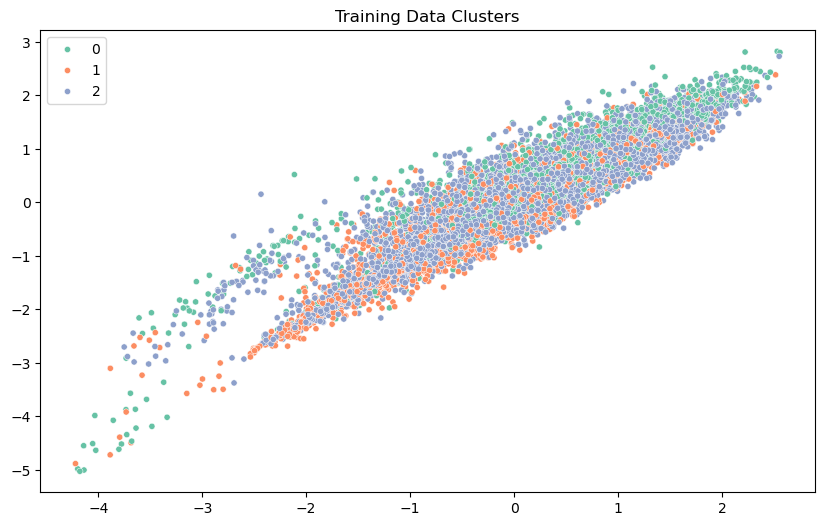

In [322]:
# Training data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_3_scaled[:, 0], y=X_train_3_scaled[:, 1], hue=train_clusters, palette=color_palette, s=dot_size)
plt.title('Training Data Clusters')
plt.show()

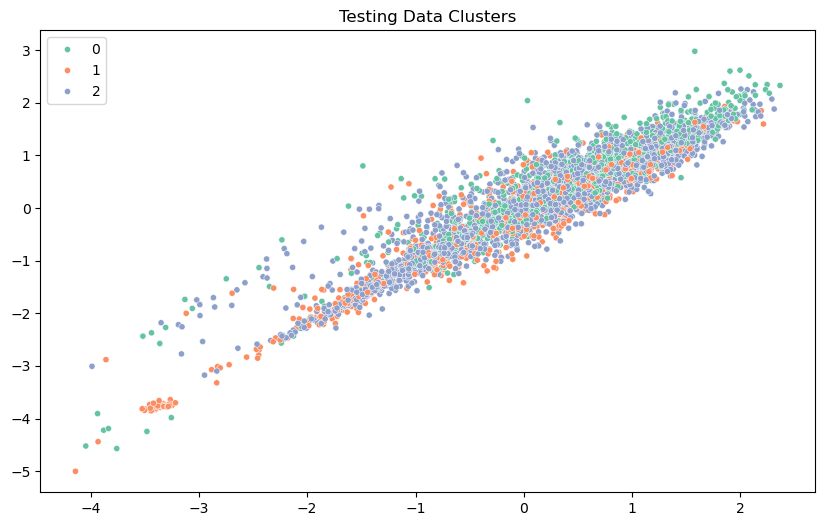

In [323]:
# Testing data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_3_scaled[:, 0], y=X_test_3_scaled[:, 1], hue=test_clusters, palette=color_palette,s=dot_size)
plt.title('Testing Data Clusters')
plt.show()

In [324]:
n_clusters=2

In [325]:
# Fit K-Means on the training data for MFCC only inputs
kmeans = KMeans(n_clusters=n_clusters, random_state=2)  
kmeans.fit(X_train_3_scaled)

KMeans(n_clusters=2, random_state=2)

In [326]:
# Predict clusters for training and testing data
train_clusters = kmeans.predict(X_train_3_scaled)
test_clusters = kmeans.predict(X_test_3_scaled)

In [327]:
color_palette = sns.color_palette("Set2", n_colors=n_clusters)
dot_size=20

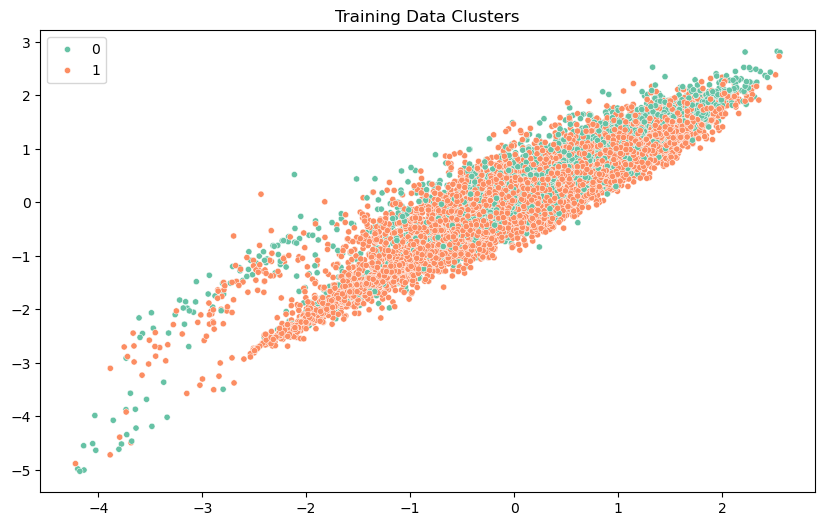

In [328]:
# Training data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_3_scaled[:, 0], y=X_train_3_scaled[:, 1], hue=train_clusters, palette=color_palette, s=dot_size)
plt.title('Training Data Clusters')
plt.show()

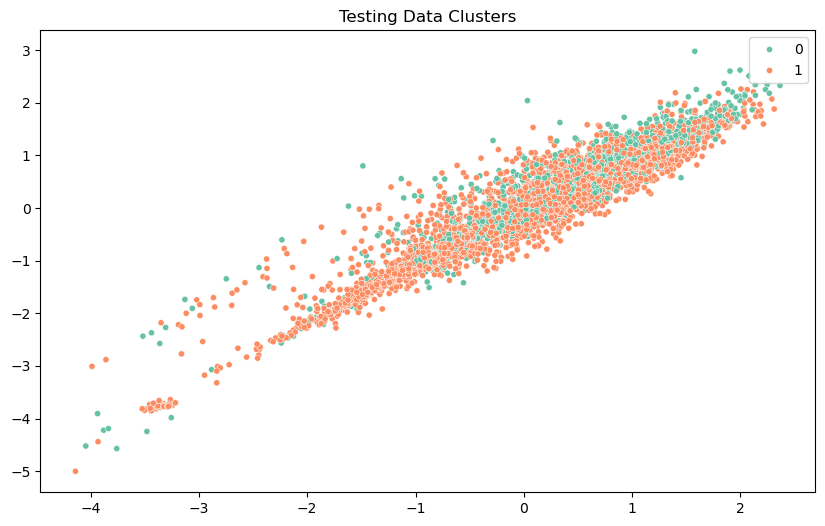

In [329]:
# Testing data clusters visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_3_scaled[:, 0], y=X_test_3_scaled[:, 1], hue=test_clusters, palette=color_palette,s=dot_size)
plt.title('Testing Data Clusters')
plt.show()